#### Connect libraries

In [1]:
# A module which contains statistical functions
import numpy as np
# pandas is a powerful open source data analysis tool
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime
import gc 
import pickle

# Plotting Packages
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# input data files
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
# turn off warning signs
import warnings
warnings.filterwarnings('ignore')

In [4]:
matplotlib.rcParams.update({'font.size': 14})

In [5]:
def evaluate_preds(true_values, pred_values):
    '''Estimating model quality and graph preds vs true'''
    
   
    print('R2:\t' + str(round(r2(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10, 10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    print("\n preds vs true\n")

In [6]:
#  Minimazing dataset size
def reduce_mem_usage(df):
    
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df



### Data Preparation



#### path to files

In [7]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'
SUBMIT_DATASET_PATH = 'sample_submission.csv'

#### Dataset description

#### Creating training data from train

In [8]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df = reduce_mem_usage(train_df)

train_df.head()

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.718750
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.093750


In [9]:
train_df.set_index('Id', inplace=True)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)


#train_df['Id'] = train_df['Id'].astype(str)


In [10]:
X = train_df
y = train_df[['Price']]

In [11]:
#del train_df
#gc.collect()

In [12]:
# there is no Price variable in Test data. we need to predict it
X_test = pd.read_csv(TEST_DATASET_PATH)
X_test =reduce_mem_usage(X_test)

X_test.head()

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.22 MB
Decreased by 70.3%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094183,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493908,42.568134,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463676,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893826,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837055,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [13]:
predict = pd.DataFrame()
predict['Id'] = X_test['Id'].copy()

X_test.set_index('Id', inplace=True)
X_test['DistrictId'] = X_test['DistrictId'].astype(str)

####  EDA and Cleaning


####  Analysing target variable 'Price' and  visualazing it with histogram 

In [14]:
X["Price"].describe()

count     10000.000000
mean     214138.937500
std       92872.273438
min       59174.777344
25%      153872.628906
50%      192269.648438
75%      249135.460938
max      633233.437500
Name: Price, dtype: float64

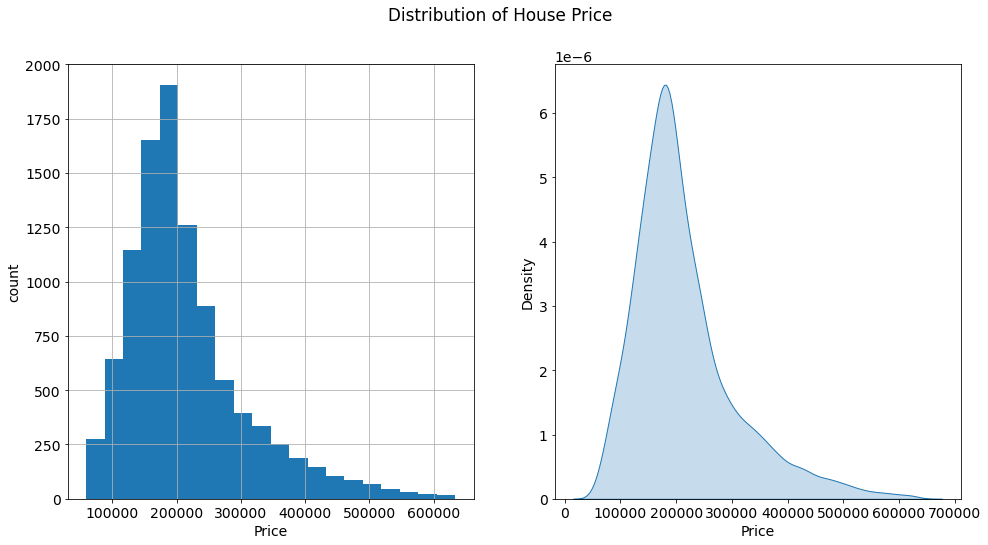

In [15]:
 plt.figure(figsize = (16, 8))

plt.subplot(121)
X['Price'].hist(density=False, bins=20)
plt.ylabel('count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(X['Price'], shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Distribution of House Price')
plt.show()

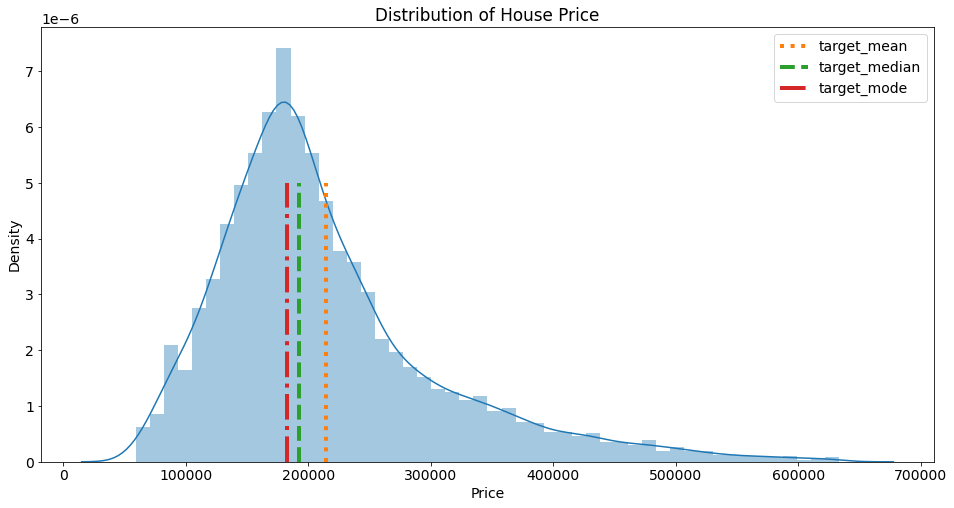

In [16]:
target_mean = round(y['Price'].mean(), 2)
target_median = y['Price'].median()
target_mode = y['Price'].mode()[0]

plt.figure(figsize = (16, 8))

sns.distplot(y['Price'], bins=50)

y = np.linspace(0, 0.000005, 10)

plt.plot([target_mean] * 10, y, label='target_mean', linestyle=':',  linewidth=4)
plt.plot([target_median] * 10, y, label='target_median', linestyle='--',  linewidth=4)
plt.plot([target_mode] * 10, y, label='target_mode', linestyle='-.', linewidth=4)

plt.title('Distribution of House Price')
plt.legend()
plt.show()

In [17]:
print("Skewness: %f" % X['Price'].skew())
print("Kurtosis: %f" % X['Price'].kurt())

Skewness: 1.366877
Kurtosis: 2.249410


##### Has appreciable positive skewness.
#####  Shows peakedness.

In [18]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 11809 to 7202
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   DistrictId     10000 non-null  object  
 1   Rooms          10000 non-null  float32 
 2   Square         10000 non-null  float32 
 3   LifeSquare     7887 non-null   float32 
 4   KitchenSquare  10000 non-null  float32 
 5   Floor          10000 non-null  int8    
 6   HouseFloor     10000 non-null  float32 
 7   HouseYear      10000 non-null  int32   
 8   Ecology_1      10000 non-null  float32 
 9   Ecology_2      10000 non-null  category
 10  Ecology_3      10000 non-null  category
 11  Social_1       10000 non-null  int8    
 12  Social_2       10000 non-null  int16   
 13  Social_3       10000 non-null  int16   
 14  Healthcare_1   5202 non-null   float32 
 15  Helthcare_2    10000 non-null  int8    
 16  Shops_1        10000 non-null  int8    
 17  Shops_2        10000 non-nul

#### Numerical variables

In [19]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
Rooms,10000.0,1.890500,0.839522,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315720,21.058716,1.136859,41.774879,52.513309,65.900627,6.410652e+02
LifeSquare,7887.0,37.199665,86.241219,0.370619,22.769833,32.781261,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560839,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.776200,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218670e-01
Social_1,10000.0,24.687000,17.532614,0.000000,6.000000,25.000000,36.000000,7.400000e+01
Social_2,10000.0,5352.157400,4006.799803,168.000000,1564.000000,5285.000000,7227.000000,1.908300e+04


### Outliers

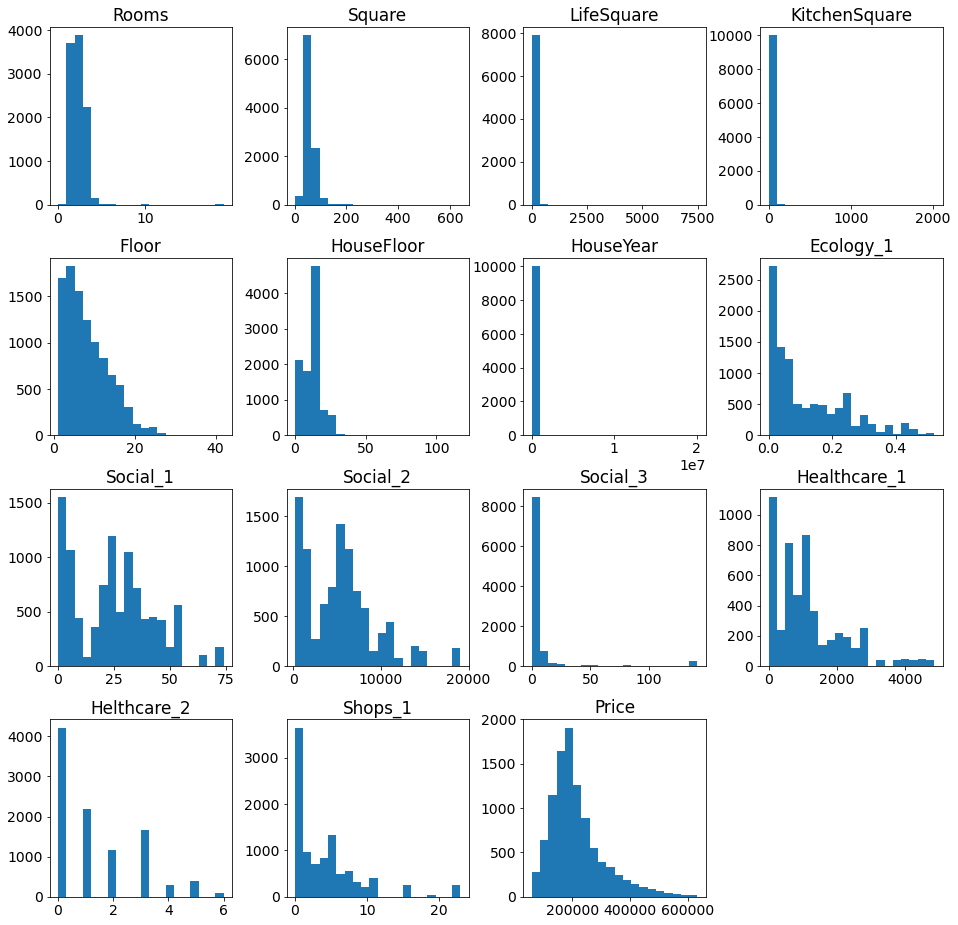

In [20]:
df_num_features = X.select_dtypes(include=['float32', 'float64', 'int8', 'int16', 'int32'])

df_num_features.hist(figsize=(16, 16), bins=20, grid=False)
plt.show()


We can see outliers at features HouseYear and KitchenSquare. Extremely high values at HouseFloor, LifeSquare, Rooms, Square.

#### Rooms

In [21]:
X['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

In [22]:
for feat in ['Rooms', 'KitchenSquare', 'HouseFloor']:
    print(f'{feat}=0: {X.loc[(X[feat] == 0)].shape[0]}')

Rooms=0: 8
KitchenSquare=0: 697
HouseFloor=0: 269


In [23]:
X['KitchenSquare'].value_counts().sort_values()

75.0         1
39.0         1
23.0         1
123.0        1
40.0         1
48.0         1
21.0         1
72.0         1
27.0         1
63.0         1
1970.0       1
29.0         1
2014.0       1
66.0         1
78.0         1
35.0         1
42.0         1
73.0         1
60.0         1
84.0         1
26.0         1
54.0         1
36.0         1
53.0         1
96.0         1
31.0         1
62.0         1
30.0         2
25.0         2
43.0         2
32.0         2
37.0         2
58.0         2
51.0         2
112.0        2
41.0         2
22.0         3
2.0          4
18.0         6
19.0        11
17.0        12
20.0        14
16.0        16
3.0         22
15.0        31
4.0         39
14.0        51
13.0        67
11.0       233
12.0       249
7.0        609
0.0        697
9.0        843
6.0       1038
10.0      1075
5.0       1169
8.0       1306
1.0       2460
Name: KitchenSquare, dtype: int64

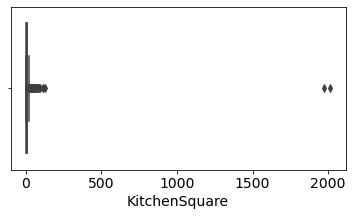

In [24]:
plt.figure(figsize=(6, 3))

sns.boxplot(X['KitchenSquare'], whis=1.5)

plt.xlabel('KitchenSquare')
plt.show()

#### Square

In [25]:
X[X['KitchenSquare'] > X['Square']]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
6569,27,1.0,38.220257,18.716856,84.0,4,17.0,2018,0.011654,B,B,4,915,0,NaN,0,0,B,99079.960938
13703,42,1.0,38.071693,19.723547,73.0,9,10.0,2006,0.158249,B,B,21,5731,0,NaN,1,0,B,160488.031250
14679,81,1.0,32.276665,19.278395,1970.0,6,1.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,105539.554688
14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,B,B,2,629,1,NaN,0,0,A,108337.484375


In [26]:
dict(np.around(X['Square']).value_counts().sort_values())

{183.0: 1,
 199.0: 1,
 16.0: 1,
 200.0: 1,
 14.0: 1,
 124.0: 1,
 22.0: 1,
 120.0: 1,
 157.0: 1,
 605.0: 1,
 409.0: 1,
 130.0: 1,
 213.0: 1,
 186.0: 1,
 132.0: 1,
 276.0: 1,
 191.0: 1,
 129.0: 1,
 641.0: 1,
 1.0: 1,
 156.0: 1,
 161.0: 1,
 128.0: 1,
 149.0: 1,
 175.0: 1,
 187.0: 1,
 140.0: 1,
 151.0: 1,
 137.0: 2,
 20.0: 2,
 19.0: 2,
 148.0: 2,
 24.0: 2,
 113.0: 2,
 169.0: 2,
 168.0: 2,
 138.0: 2,
 112.0: 2,
 4.0: 2,
 3.0: 2,
 2.0: 2,
 133.0: 2,
 170.0: 3,
 135.0: 3,
 21.0: 3,
 163.0: 3,
 23.0: 3,
 126.0: 3,
 134.0: 3,
 17.0: 4,
 139.0: 4,
 115.0: 4,
 111.0: 4,
 136.0: 5,
 127.0: 5,
 119.0: 5,
 114.0: 5,
 5.0: 5,
 118.0: 5,
 123.0: 5,
 109.0: 5,
 25.0: 6,
 121.0: 6,
 117.0: 7,
 107.0: 7,
 26.0: 7,
 116.0: 7,
 125.0: 7,
 110.0: 8,
 100.0: 8,
 95.0: 8,
 122.0: 10,
 108.0: 10,
 106.0: 11,
 28.0: 12,
 27.0: 12,
 105.0: 12,
 97.0: 12,
 101.0: 16,
 94.0: 16,
 104.0: 16,
 93.0: 17,
 91.0: 17,
 103.0: 19,
 98.0: 19,
 102.0: 19,
 92.0: 20,
 99.0: 22,
 96.0: 24,
 29.0: 25,
 90.0: 27,
 89.0: 30,
 3

#### Floor

In [27]:
X['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int8)

In [28]:
X['Floor'].value_counts().sort_values()

31      1
37      1
42      1
33      1
32      2
28      3
27      5
26     18
23     25
25     34
24     53
22     54
21     59
20     68
19    121
18    185
1     235
17    256
15    287
16    290
14    362
13    398
12    438
11    457
10    553
2     588
9     604
8     643
7     759
6     802
3     872
5     876
4     949
Name: Floor, dtype: int64

#### HouseFloor

In [29]:
X['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.],
      dtype=float32)

In [30]:
np.around(X['HouseFloor']).value_counts().sort_values()

26.0        1
29.0        1
44.0        1
47.0        1
45.0        1
31.0        1
38.0        1
117.0       1
36.0        1
39.0        2
99.0        2
48.0        2
28.0        3
32.0        4
37.0        4
27.0        6
40.0        7
30.0       21
13.0       27
11.0       28
21.0       33
23.0       40
2.0        48
6.0        58
7.0        59
18.0       89
20.0      105
19.0      108
15.0      123
3.0       127
4.0       134
10.0      135
8.0       141
24.0      176
0.0       269
22.0      343
25.0      374
1.0       497
16.0      576
14.0      625
5.0      1031
12.0     1074
9.0      1389
17.0     2331
Name: HouseFloor, dtype: int64

In [31]:
(X['Floor'] > X['HouseFloor']).sum()

1825

#### HouseYear

In [32]:
X['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

#### LifeSquare

In [33]:
dict(np.around(X['LifeSquare']).value_counts().sort_values())

{0.0: 1,
 162.0: 1,
 93.0: 1,
 108.0: 1,
 202.0: 1,
 117.0: 1,
 234.0: 1,
 171.0: 1,
 137.0: 1,
 119.0: 1,
 103.0: 1,
 154.0: 1,
 114.0: 1,
 123.0: 1,
 109.0: 1,
 107.0: 1,
 638.0: 1,
 138.0: 1,
 111.0: 1,
 161.0: 1,
 110.0: 1,
 136.0: 1,
 9.0: 1,
 411.0: 1,
 264.0: 1,
 164.0: 1,
 165.0: 1,
 127.0: 1,
 122.0: 1,
 211.0: 1,
 7481.0: 1,
 461.0: 1,
 175.0: 1,
 118.0: 1,
 139.0: 1,
 113.0: 2,
 94.0: 2,
 125.0: 2,
 121.0: 2,
 115.0: 2,
 126.0: 2,
 99.0: 2,
 101.0: 3,
 96.0: 3,
 106.0: 3,
 98.0: 3,
 91.0: 4,
 100.0: 4,
 104.0: 4,
 92.0: 4,
 105.0: 4,
 102.0: 5,
 88.0: 6,
 12.0: 6,
 89.0: 6,
 14.0: 7,
 95.0: 7,
 97.0: 7,
 90.0: 7,
 84.0: 7,
 11.0: 8,
 87.0: 8,
 13.0: 10,
 71.0: 11,
 86.0: 11,
 85.0: 12,
 83.0: 12,
 76.0: 12,
 72.0: 13,
 70.0: 14,
 74.0: 14,
 73.0: 15,
 75.0: 16,
 81.0: 16,
 78.0: 17,
 77.0: 17,
 69.0: 18,
 82.0: 19,
 68.0: 19,
 80.0: 19,
 6.0: 24,
 79.0: 25,
 15.0: 27,
 1.0: 27,
 66.0: 30,
 59.0: 32,
 3.0: 34,
 60.0: 34,
 67.0: 36,
 65.0: 36,
 4.0: 36,
 63.0: 37,
 62.0: 37,
 

In [34]:
(X['LifeSquare'] > X['Square']).sum()

482

In [35]:
X[X['HouseYear'] > 2020].head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
11607,147,2.0,44.791836,28.360394,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B,243028.609375
10814,109,1.0,37.265072,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B,254084.531250


#### Missing data

In [36]:
total = X.isnull().sum().sort_values(ascending=False)
percent = (X.isnull().sum()/X.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Healthcare_1,4798,0.4798
LifeSquare,2113,0.2113
DistrictId,0,0.0000
Ecology_3,0,0.0000
Shops_2,0,0.0000
Shops_1,0,0.0000
Helthcare_2,0,0.0000
Social_3,0,0.0000
Social_2,0,0.0000
Social_1,0,0.0000


#### DistrictId

In [37]:
X.DistrictId.nunique()

205

In [38]:
dict(X['DistrictId'].value_counts())

{'27': 851,
 '1': 652,
 '23': 565,
 '6': 511,
 '9': 294,
 '62': 247,
 '30': 228,
 '58': 179,
 '53': 174,
 '21': 165,
 '52': 143,
 '8': 142,
 '11': 129,
 '46': 119,
 '61': 118,
 '45': 116,
 '74': 114,
 '34': 111,
 '57': 107,
 '44': 104,
 '47': 97,
 '13': 97,
 '99': 97,
 '101': 97,
 '7': 92,
 '48': 90,
 '29': 89,
 '94': 89,
 '41': 87,
 '3': 82,
 '84': 80,
 '28': 79,
 '2': 78,
 '22': 78,
 '25': 77,
 '85': 76,
 '93': 73,
 '90': 72,
 '37': 72,
 '96': 71,
 '59': 67,
 '75': 66,
 '26': 65,
 '12': 64,
 '88': 64,
 '128': 64,
 '66': 62,
 '67': 61,
 '17': 59,
 '55': 58,
 '39': 57,
 '10': 56,
 '105': 55,
 '31': 55,
 '18': 51,
 '111': 49,
 '119': 49,
 '0': 48,
 '78': 46,
 '91': 44,
 '129': 43,
 '124': 43,
 '63': 43,
 '79': 42,
 '42': 42,
 '109': 41,
 '113': 41,
 '77': 40,
 '54': 37,
 '38': 36,
 '15': 36,
 '24': 35,
 '32': 34,
 '56': 34,
 '5': 34,
 '103': 33,
 '123': 32,
 '83': 31,
 '80': 31,
 '33': 31,
 '19': 31,
 '130': 29,
 '69': 29,
 '138': 29,
 '64': 28,
 '86': 27,
 '108': 27,
 '87': 27,
 '70': 

### Cleaning the data

In [39]:
median = X[['Square', 'KitchenSquare', 'LifeSquare', 'Rooms', 'HouseFloor']].median()

median

Square           52.513309
KitchenSquare     6.000000
LifeSquare       32.781261
Rooms             2.000000
HouseFloor       13.000000
dtype: float32

#### Data preparation

Rooms  0: 8
KitchenSquare  0: 697
HouseFloor  0: 269

#### Outliers
Rooms < 1 & Rooms > 6
Square < 15 & Square > 3
LifeSquare < 10 & LifeSquare > 250
KitchenSquare < 3 & KitchenSquare > 30
HouseFloor < 1 & HouseFloor > 50
HouseYear > 2020

#### Missing data
Filling in LifeSquare = 21% пропусков
Deleting Healthcare_1  48% пропусков

In [40]:
class DataPipeLine:
   
    
    def __init__(self):
        
        
        self.medians = None
       
        self.Square_min = 15
        self.Square_max = 300
        
        self.KitchenSquare_min = 3
        self.KitchenSquare_max = 30
        
        self.LifeSquare_min = 10
        self.LifeSquare_max = 250
        
        self.Rooms_min = 1
        self.Rooms_max = 6
        
        self.HouseFloor_min = 1
        self.HouseFloor_max = 50
        
        self.HouseYear_max = 2020
        
        self.DistrictId_value_counts = None
        self.MSquarePrice_DistrictId = None
        self.Healthcare_1_DistrictId = None

        
    def fit(self, df):
       
        
        #self.median = df[['Square', 'KitchenSquare', 'LifeSquare', 'Rooms', 'HouseFloor', 'HouseYear']].median()
        self.medians = df.median()
        
        # popular district count
        self.DistrictId_value_counts = dict(df['DistrictId'].value_counts())
        
        # Average metre square price:
        df_temp = df.loc[((df['Square'] > self.Square_min) & (df['Square'] < self.Square_max))]
        
        df_temp["MSquarePrice"] = df_temp["Price"] / df_temp["Square"]
        self.MSquarePrice_DistrictId = df_temp.groupby('DistrictId', as_index=False)\
            .agg({'MSquarePrice': 'mean'})\
            .rename(columns={'MSquarePrice': 'AverageMSquarePrice'})
      
        del df_temp
        
    def transform(self, df):
       
        
        # Cleaning missing data
        
        # LifeSquare missing 21%
        df[['LifeSquare', 'HouseFloor']] = df[['LifeSquare', 'HouseFloor']].fillna(self.medians)
        #df['LifeSquare'] = df['LifeSquare'].fillna(self.medians['LifeSquare'])
        #df['LifeSquare'].fillna(df['LifeSquare'].median(), inplace=True)
                
        # Healthcare_1 missing 48% 
        if 'Healthcare_1' in df.columns:
            # df = df.drop(['Healthcare_1'], axis=1)
            df.drop('Healthcare_1', axis=1, inplace=True)
        
        
        
        # Cleaning outliers
        
        # Rooms 
        df['Rooms_outlier'] = 0
        df.loc[(df['Rooms'] == 0) | (df['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        df.loc[df['Rooms'] == 0, 'Rooms'] = self.Rooms_min
        df.loc[df['Rooms'] >= self.Rooms_max, 'Rooms'] = self.medians['Rooms'] 
        
       
         # HouseFloor 
        df['HouseFloor_outlier'] = 0
        df.loc[df['HouseFloor'] < self.HouseFloor_min, 'HouseFloor_outlier'] = 1
        df.loc[df['Floor'] > df['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        df.loc[df['HouseFloor'] < self.HouseFloor_min, 'HouseFloor'] = self.medians['HouseFloor']
        
        
        df.loc[df['Floor'] > df['HouseFloor'], 'Floor'] = \
            df.loc[df['Floor'] > df['HouseFloor'], 'HouseFloor'] 
           
            
        # HouseYear 
        current_year = datetime.now().year
        df['HouseYear_outlier'] = 0
        df.loc[df['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        df.loc[(df['HouseYear'] > self.HouseYear_max), 'HouseYear'] = current_year
        
       
        # KitchenSquare
        df.loc[df['KitchenSquare'] < self.KitchenSquare_min, 'KitchenSquare'] = self.KitchenSquare_min
        df.loc[(df['KitchenSquare'] > self.KitchenSquare_max), 'KitchenSquare'] = self.medians['KitchenSquare']


        # Square
        # df.loc[(df['Square'] > self.Square_max), 'Square'] = self.Square_max
        # df.loc[(df['Square'] < self.Square_min), 'Square'] = self.Square_min
        df.loc[(df['Square'] < self.Square_min) | \
               (df['Square'] > self.Square_max), 'Square'] = self.medians['Square']
        
        
        # LifeSquare
        df.loc[(df['LifeSquare'] < self.LifeSquare_min), 'LifeSquare'] = self.Square_min
        df.loc[(df['LifeSquare'] > self.LifeSquare_max), 'LifeSquare'] = self.medians['LifeSquare']
                
       
        
        # Processing categorical variables 
        df = pd.concat([df, pd.get_dummies(df['Ecology_2'], prefix='Ecology_2', dtype='int8')], axis=1)
        df = pd.concat([df, pd.get_dummies(df['Ecology_3'], prefix='Ecology_3', dtype='int8')], axis=1)
        df = pd.concat([df, pd.get_dummies(df['Shops_2'], prefix='Shops_2', dtype='int8')], axis=1)
        
        return df
    
  
    def features(self, df):
        # Feature engineering
            
        
        # adding new feature popular Disctric
        df['DistrictId_counts'] = df['DistrictId'].map(self.DistrictId_value_counts)
        df['DistrictId_counts'].fillna(df['DistrictId_counts'].median(), inplace=True)
        
        # adding new feature Metre Square Price by DistrictId
        df = df.merge(self.MSquarePrice_DistrictId, on=["DistrictId"], how='left')
        df['AverageMSquarePrice'].fillna(df['AverageMSquarePrice'].median(), inplace=True)
        
        return df

In [41]:
dpl = DataPipeLine()

#training data

dpl.fit(X)


In [42]:
X = dpl.transform(X)
X = dpl.features(X)

X_test = dpl.transform(X_test)
X_test = dpl.features(X_test)

#### Features selection

In [43]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
Rooms,10000.0,1.887600,0.811425,1.000000,1.000000,2.000000,2.000000,5.000000
Square,10000.0,56.228401,19.058779,16.117155,41.800063,52.513309,65.889736,275.645294
LifeSquare,10000.0,35.593018,15.491379,10.523869,25.527400,32.781261,41.410882,233.949310
KitchenSquare,10000.0,6.400200,3.096711,3.000000,3.000000,6.000000,9.000000,30.000000
Floor,10000.0,7.918200,5.186386,1.000000,4.000000,7.000000,11.000000,42.000000
HouseFloor,10000.0,12.959100,6.443573,1.000000,9.000000,13.000000,17.000000,117.000000
HouseYear,10000.0,1984.872600,18.416734,1910.000000,1974.000000,1977.000000,2001.000000,2021.000000
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,0.521867
Social_1,10000.0,24.687000,17.532614,0.000000,6.000000,25.000000,36.000000,74.000000
Social_2,10000.0,5352.157400,4006.799803,168.000000,1564.000000,5285.000000,7227.000000,19083.000000


In [44]:
X.columns.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'HouseYear_outlier',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B',
 'DistrictId_counts',
 'AverageMSquarePrice']

##### Relationship with numerical vriables 

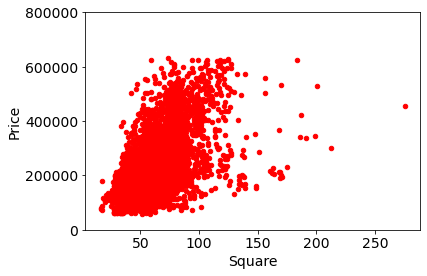

In [45]:
var = 'Square'
data = pd.concat([X['Price'], X[var]], axis=1)
data.plot.scatter(x=var, y="Price", ylim = (0,800000), color='r');

<AxesSubplot:xlabel='LifeSquare', ylabel='Price'>

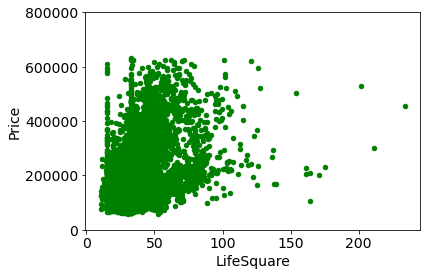

In [46]:
var = 'LifeSquare'
data = pd.concat([X['Price'], X[var]], axis=1)
data.plot.scatter(x=var, y="Price", ylim = (0,800000), color ='g')

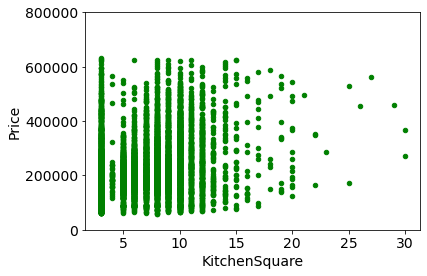

In [47]:
var = 'KitchenSquare'
data = pd.concat([X['Price'], X[var]], axis=1)
data.plot.scatter(x=var, y="Price", ylim = (0,800000), color ='g');

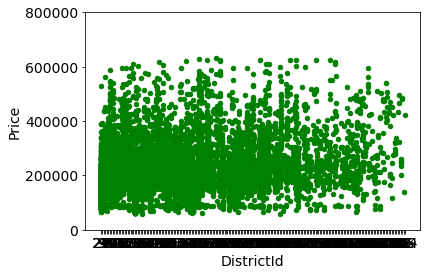

In [48]:
var = 'DistrictId'
data = pd.concat([X['Price'], X[var]], axis=1)
data.plot.scatter(x=var, y="Price", ylim = (0,800000), color ='g');

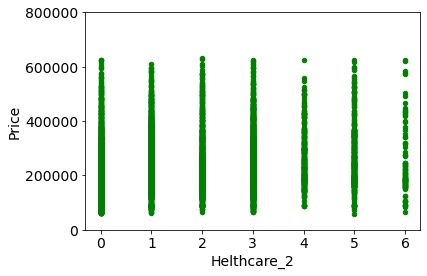

In [49]:
var = 'Helthcare_2'
data = pd.concat([X['Price'], X[var]], axis=1)
data.plot.scatter(x=var, y="Price", ylim = (0,800000), color= 'g');

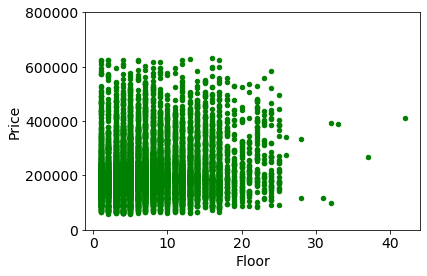

In [50]:
var = 'Floor'
data = pd.concat([X['Price'], X[var]], axis=1)
data.plot.scatter(x=var, y="Price", ylim = (0,800000), color= 'g');

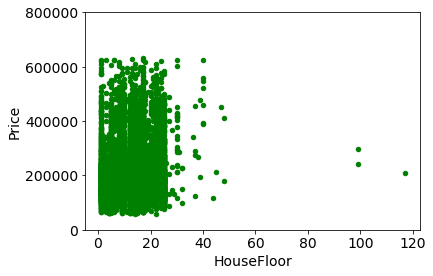

In [51]:
var = 'HouseFloor'
data = pd.concat([X['Price'], X[var]], axis=1)
data.plot.scatter(x=var, y="Price", ylim = (0,800000), color= 'g');

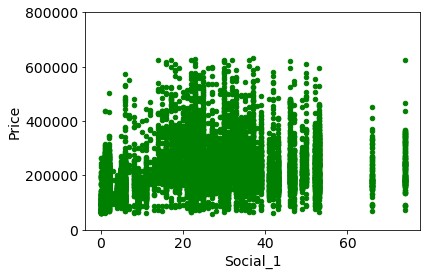

In [52]:
var = 'Social_1'
data = pd.concat([X['Price'], X[var]], axis=1)
data.plot.scatter(x=var, y="Price", ylim = (0,800000), color= 'g');

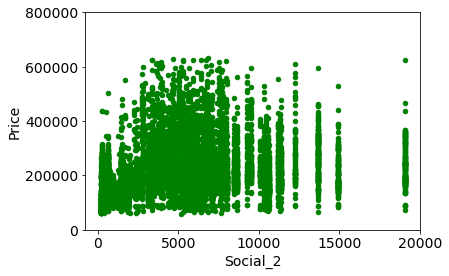

In [53]:
var = 'Social_2'
data = pd.concat([X['Price'], X[var]], axis=1)
data.plot.scatter(x=var, y="Price", ylim = (0,800000), color= 'g');

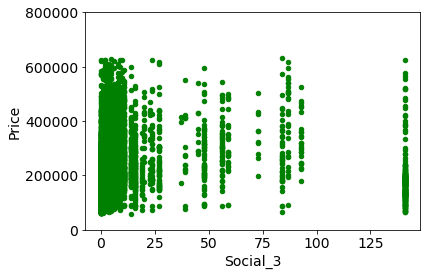

In [54]:
var = 'Social_3'
data = pd.concat([X['Price'], X[var]], axis=1)
data.plot.scatter(x=var, y="Price", ylim = (0,800000), color= 'g');

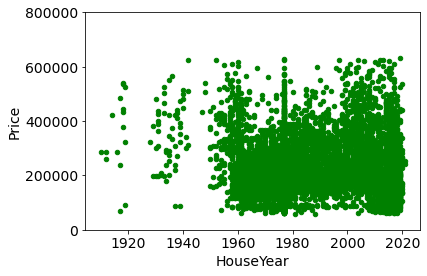

In [55]:
var = 'HouseYear'
data = pd.concat([X['Price'], X[var]], axis=1)
data.plot.scatter(x=var, y="Price", ylim = (0,800000), color= 'g');

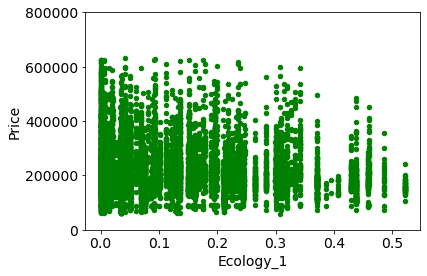

In [56]:
var = 'Ecology_1'
data = pd.concat([X['Price'], X[var]], axis=1)
data.plot.scatter(x=var, y="Price", ylim = (0,800000), color= 'g');

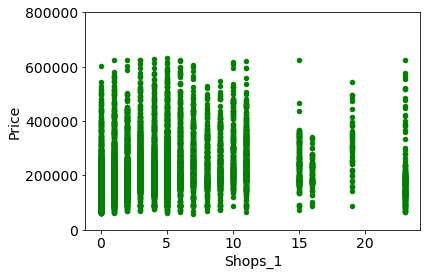

In [57]:
var = 'Shops_1'
data = pd.concat([X['Price'], X[var]], axis=1)
data.plot.scatter(x=var, y="Price", ylim = (0,800000), color= 'g');

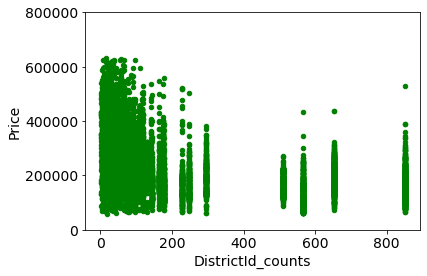

In [58]:
var = 'DistrictId_counts'
data = pd.concat([X['Price'], X[var]], axis=1)
data.plot.scatter(x=var, y="Price", ylim = (0,800000), color= 'g');

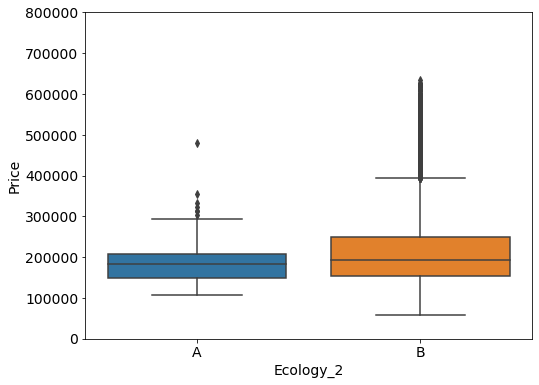

In [59]:
var = 'Ecology_2'
data = pd.concat([X["Price"],  X[var]], axis=1)
f, ax = plt.subplots(figsize = (8, 6))
fig = sns.boxplot(x=var, y="Price", data=data)
fig.axis(ymin =0, ymax=800000);

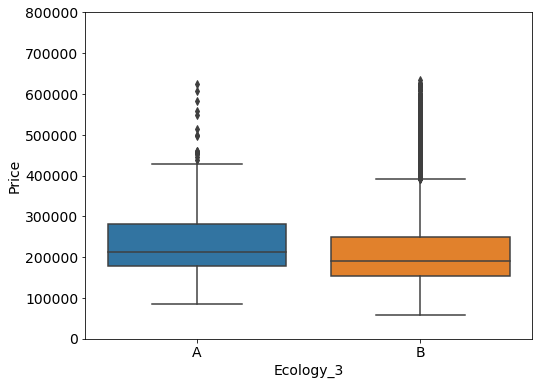

In [60]:
var = 'Ecology_3'
data = pd.concat([X["Price"],  X[var]], axis=1)
f, ax = plt.subplots(figsize = (8, 6))
fig = sns.boxplot(x=var, y="Price", data=data)
fig.axis(ymin =0, ymax=800000);

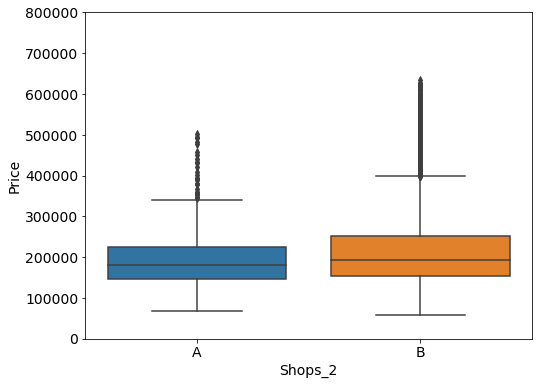

In [61]:
var = 'Shops_2'
data = pd.concat([X["Price"],  X[var]], axis=1)
f, ax = plt.subplots(figsize = (8, 6))
fig = sns.boxplot(x=var, y="Price", data=data)
fig.axis(ymin =0, ymax=800000);

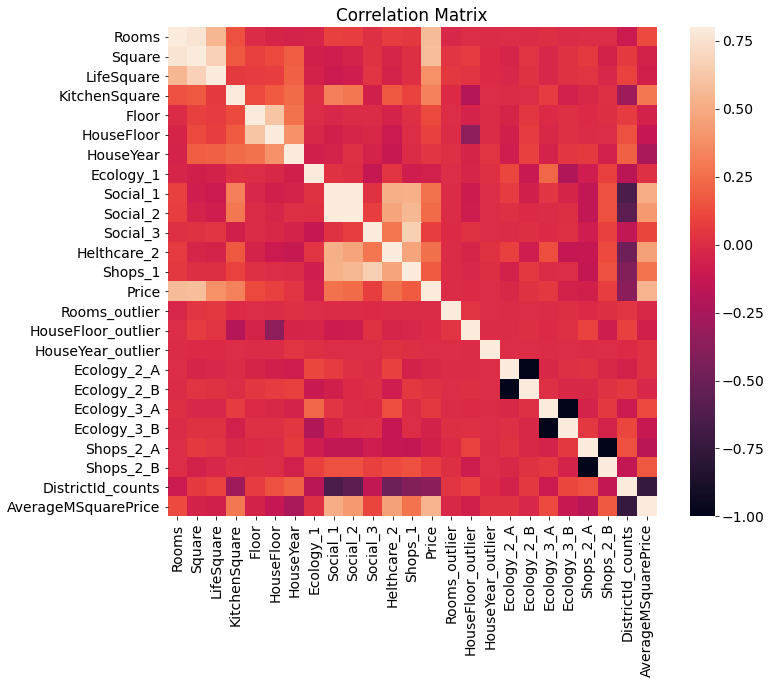

In [62]:
corrmat = X.corr()
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, data=corrmat, vmax = .8, square=True, fmt='.1f');
plt.title('Correlation Matrix')
plt.show()

In [63]:
selected_features = ['Square',
                 'AverageMSquarePrice',
                 'Rooms',
                 'HouseYear',
                 'KitchenSquare', 
                 'LifeSquare',
                 'Social_1',
                 'Social_2',
                 'HouseFloor',
                 'Social_3',
                 'Floor']

In [64]:
target = 'Price'

####  train/test

In [65]:
X = X[selected_features + [target]]

In [66]:
y = X[target]
X = X[selected_features]
X_test = X_test[selected_features]


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

#### Building a model

#### Random Forrest Regression

In [117]:
%%time


rf_model = RandomForestRegressor( max_depth=8, min_samples_leaf=25,  random_state=42,
                                 n_estimators=200)



cv_score = cross_val_score(rf_model, X, y,
                           scoring='r2',
                           cv=KFold(n_splits=5,
                                    shuffle=True,
                                    random_state=66))

# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.741 +- 0.014
CPU times: user 13.7 s, sys: 31.1 ms, total: 13.7 s
Wall time: 13.7 s


In [120]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, min_samples_leaf=25, n_estimators=200,
                      random_state=42)

In [121]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

R2:	0.776

 preds vs true

R2:	0.73

 preds vs true



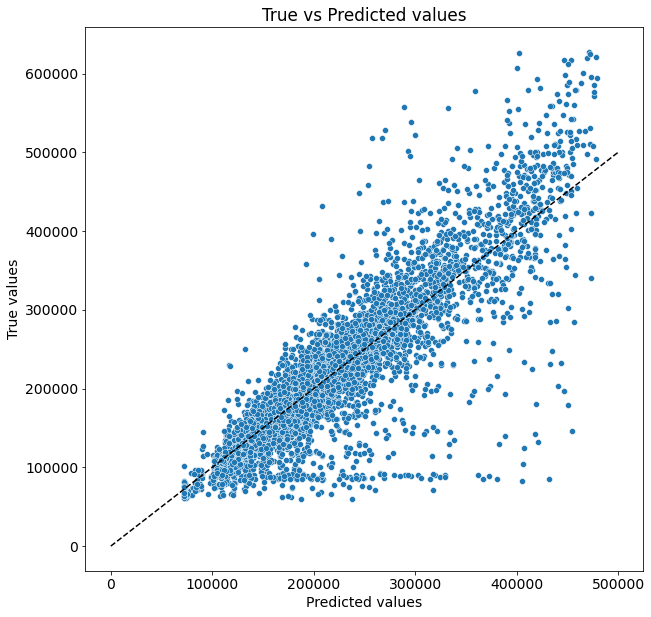

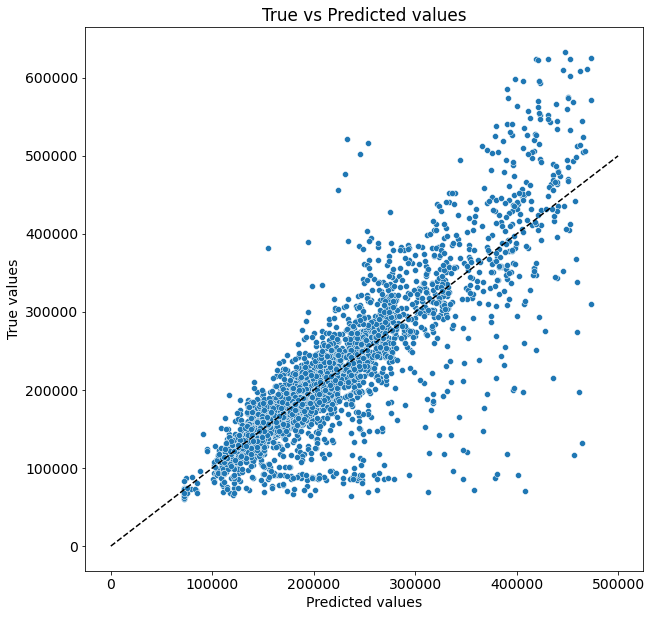

In [122]:
evaluate_preds(y_train, y_train_preds)
evaluate_preds(y_valid, y_test_preds)

#### Features importances graph

In [123]:
def plot_feature_importances(importances, X):
   
    
    index_sort = np.argsort(importances)[::-1]
    print(index_sort)
    
    plt.figure(figsize=(10, 6))
    
    plt.title('Feature importances', fontsize=12)
    plt.bar(range(X.shape[1], importances[index_sort] / importances.sum(), color='darkred', align='center'))
    plt.xticks(range(X.shape[1]), X.columns[index_sort], rotation=90, fontsize=12)
    plt.xlim([-1, X.shape[1]])
    
    plt.tight_layout()
    plt.show()

In [124]:
feature_importances = pd.DataFrame(zip(X.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances

,feature_name,importance
0,Square,0.487391
1,AverageMSquarePrice,0.431793
2,Rooms,0.033306
6,Social_1,0.009709
4,KitchenSquare,0.008658
7,Social_2,0.007949
3,HouseYear,0.006674
8,HouseFloor,0.004138
5,LifeSquare,0.004000
10,Floor,0.003843


In [125]:
y_train_preds = rf_model.predict(X)
print("R2:\t" + str(round(r2(y, y_train_preds), 3)))

R2:	0.76


In [126]:
X_test.head().T

,0,1,2,3,4
Square,36.847630,42.493908,59.463676,49.646030,53.837055
AverageMSquarePrice,4572.483887,2818.749268,2766.023193,2284.108643,3355.343018
Rooms,1.000000,1.000000,2.000000,3.000000,1.000000
HouseYear,1970.000000,2017.000000,1977.000000,1965.000000,1977.000000
KitchenSquare,5.000000,10.000000,9.000000,6.000000,3.000000
LifeSquare,19.094183,42.568134,32.781261,33.893826,32.781261
Social_1,24.000000,2.000000,9.000000,2.000000,35.000000
Social_2,4378.000000,629.000000,1892.000000,475.000000,7715.000000
HouseFloor,9.000000,17.000000,19.000000,2.000000,17.000000
Social_3,0.000000,1.000000,0.000000,0.000000,4.000000


In [127]:
X_test.shape


(5000, 11)

In [128]:
y_test_preds = rf_model.predict(X_test)

predict['Price'] = y_test_preds

# Выгружаем предсказания в файл
predict.to_csv('Fridlyand_predict_submit.csv', index=False, encoding='utf-8', sep=',')

predict.head()

,Id,Price
0,4567,170530.733860
1,5925,122573.476160
2,960,150878.434699
3,3848,137613.414264
4,746,163239.849230


In [129]:
predict.shape

(5000, 2)